In [1]:
# 使用微生物遗传算法作为搜索策略进行网络搜索test
# Standard imports
from nasbench import api
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

NASBENCH_PATH = r"/workspace/Code1/nasbench/nasbench_only108.tfrecord"
nasbench = api.NASBench(NASBENCH_PATH)
# Useful constants 有用的参数
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7     # 顶点的个数
MAX_EDGES = 9  # 为了说明最多边为9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix 
# 上三角矩阵 规定边
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed 输入/输出顶点是固定的
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]  # 允许的结构
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix 二元邻接矩阵

Loading dataset from file... This may take a few minutes...
Loaded dataset in 66 seconds


In [2]:
# 先 MGA 算法手动实现一下
 # 保存好的父母，让好的父母不消失，在袋子里抽两个球, 对比两个球, 把球大的放回袋子里, 把球小的变一下再放回袋子里
 # 这里直接使用的莫烦的代码主要学习他的而逻辑来俩作为搜索策略
import numpy as np
# import matplotlib.pyplot as plt

DNA_SIZE = 10            # DNA length
POP_SIZE = 20            # population size
CROSS_RATE = 0.6         # mating probability (DNA crossover)
MUTATION_RATE = 0.01     # mutation probability
N_GENERATIONS = 200
X_BOUND = [0, 5]         # x upper and lower bounds


def F(x): return np.sin(10*x)*x + np.cos(2*x)*x     # to find the maximum of this function  求这个函数的最大值


class MGA(object):
    def __init__(self, DNA_size, DNA_bound, cross_rate, mutation_rate, pop_size):
        self.DNA_size = DNA_size
        DNA_bound[1] += 1
        self.DNA_bound = DNA_bound
        self.cross_rate = cross_rate
        self.mutate_rate = mutation_rate
        self.pop_size = pop_size

        # initial DNAs for winner and loser
        self.pop = np.random.randint(*DNA_bound, size=(1, self.DNA_size)).repeat(pop_size, axis=0)

    def translateDNA(self, pop):
        # convert binary DNA to decimal and normalize it to a range(0, 5)
        return pop.dot(2 ** np.arange(self.DNA_size)[::-1]) / float(2 ** self.DNA_size - 1) * X_BOUND[1]

    def get_fitness(self, product):
        return product      # it is OK to use product value as fitness in here

    def crossover(self, loser_winner):      # crossover for loser
        cross_idx = np.empty((self.DNA_size,)).astype(np.bool)
        for i in range(self.DNA_size):
            cross_idx[i] = True if np.random.rand() < self.cross_rate else False  # crossover index
        loser_winner[0, cross_idx] = loser_winner[1, cross_idx]  # assign winners genes to loser
        return loser_winner

    def mutate(self, loser_winner):         # mutation for loser
        mutation_idx = np.empty((self.DNA_size,)).astype(np.bool)
        for i in range(self.DNA_size):
            mutation_idx[i] = True if np.random.rand() < self.mutate_rate else False  # mutation index
        # flip values in mutation points
        loser_winner[0, mutation_idx] = ~loser_winner[0, mutation_idx].astype(np.bool)
        return loser_winner

    def evolve(self, n):    # nature selection wrt pop's fitness
        for _ in range(n):  # random pick and compare n times
            sub_pop_idx = np.random.choice(np.arange(0, self.pop_size), size=2, replace=False)
            sub_pop = self.pop[sub_pop_idx]             # pick 2 from pop
            product = F(self.translateDNA(sub_pop))
            fitness = self.get_fitness(product)
            loser_winner_idx = np.argsort(fitness)
            loser_winner = sub_pop[loser_winner_idx]    # the first is loser and second is winner
            loser_winner = self.crossover(loser_winner)
            loser_winner = self.mutate(loser_winner)
            self.pop[sub_pop_idx] = loser_winner

        DNA_prod = self.translateDNA(self.pop)
        pred = F(DNA_prod)
        return DNA_prod, pred


# plt.ion()       # something about plotting
# x = np.linspace(*X_BOUND, 200)
# plt.plot(x, F(x))

ga = MGA(DNA_size=DNA_SIZE, DNA_bound=[0, 1], cross_rate=CROSS_RATE, mutation_rate=MUTATION_RATE, pop_size=POP_SIZE)

# for _ in range(N_GENERATIONS):                    # 100 generations
#     DNA_prod, pred = ga.evolve(5)          # natural selection, crossover and mutation

#     # something about plotting
#     if 'sca' in globals(): sca.remove()
#     sca = plt.scatter(DNA_prod, pred, s=200, lw=0, c='red', alpha=0.5); plt.pause(0.05)

# plt.ioff();plt.show()

In [3]:
# 正式开始使用NASbaech101实现以下MGA算法
# 创建一个随机空间
# import api
def random_spec(mean=None, var=None):
  """返回一个随机的验证空间"""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES,size=(NUM_VERTICES,NUM_VERTICES))  # 第一个参数规定了矩阵的维度
    matrix = np.triu(matrix,1) # 获得矩阵的上三角 ，1对第一个对角线以下的元素归零
    ops = np.random.choice(ALLOWED_OPS,size=(NUM_VERTICES)).tolist() # 创建一个随机结构从允许结构中选择，7个顶点，并转化成列表（？）
    ops[0] = INPUT  # 将可选结构列表修改第一个改成固定结构，input
    ops[-1]  = OUTPUT # 将可选结构列表修改最后一个改成固定结构，output
    spec = api.ModelSpec(matrix=matrix, ops=ops) # 构建规定结构和初始化举证为随机矩阵的模型空间
    if nasbench.is_valid(spec):
      '''验证模型空间可行性'''
      return spec

In [4]:
# 对于ops理解
testops = [CONV3X3, CONV1X1, MAXPOOL3X3]
test_ops = np.random.choice(testops,size=(NUM_VERTICES))# 创建一个

print(test_ops[0])

conv1x1-bn-relu


In [5]:
# 设定变异空间
# 这里变异空间也就是遗传算法中的变异规则先用官方给出示例，同样交配规则也暂时不改变，沿用官方

# 设定变异规则：变异邻接矩阵上三角，为什么是上三角，模型只存在单向连接，如果更改上三角一下的数字存在双线。
def mutate_spec(old_spec,mutation_rate=1.0):
    '''默认规定变异率为1.0'''
    while True:
      new_matrix = copy.deepcopy(old_spec.original_matrix) # 深拷贝原始矩阵
      new_ops = copy.deepcopy(old_spec.original_ops) # 同上
      # 变异规则：改变原来的连接性，即连接的断开不连接连接上（注意这里时要在上面随机选择时对应点的改变）
      # V边翻转（注意大多数最终被修减）
      edge_mutation_prob = mutation_rate / NUM_VERTICES # 边变异可能性
      for src in range(0,NUM_VERTICES - 1):
          '''# 输出[0|1|2|3|4|5]，用来取得old_spec矩阵的上三角'''
          for dst in range(src +1, NUM_VERTICES):
              '''# 输出[1,2,3,4,5,6|2,3,4,5,6|3,4,5,6|4,5,6|5,6|6]
              下面变异规则'''
              if random.random() < edge_mutation_prob:  # 选取一个随机数如果这个随机数小于边变异可能性则对对应边进行变异
                  new_matrix[src, dst] = 1 - new_matrix[src, dst]  # 变异规则

      # 变异点也就是ops 在预期中，一个op被重采样
      # 变异规则
      op_mutation_prob = mutation_rate / OP_SPOTS  #点变异的可能性
      # 变异ops列表
      for ind in range(1, NUM_VERTICES - 1):
        '''ind = 1,2,3,4,5,6 对位置进行选择
        '''
        if random.random() < op_mutation_prob:
          available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]  # 有效点
          new_ops[ind] = random.choice(available) # 从随机选择出来的结构中再随机选择替换ind位置的结构

      new_spec = api.ModelSpec(new_matrix, new_ops) # 新的矩阵和结构构成新的模型空间
      # 验证模型可行性
      if nasbench.is_valid(new_spec):
        return new_spec

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import app
from nasbench import api
import time

In [7]:
# # 测试变异规则函数输出
# random_spec = random_spec()
# old_space = random_spec
# print(old_space.original_matrix)
# print('\n')
# n_matrix = copy.deepcopy(old_space.original_matrix)
# ep = 1 / 7
# for src in range(0,NUM_VERTICES - 1):
#     ''''''
    
#     for dst in range(src +1, NUM_VERTICES):
#         ''''''
#         if random.random() < ep:
#             n_matrix[src, dst] = 1 - n_matrix[src, dst]
# print(n_matrix)

In [8]:
 # 随机的空间不方便观察变异规则下面指定固定结构空间然后查看变异规则
 old_space1 = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])
 
 print(old_space1.original_matrix)
 print('\n')

 n_matrix = copy.deepcopy(old_space1.original_matrix)
ep = 1 / 7
for src in range(0,NUM_VERTICES - 1):
    '''输出矩阵行'''
    # print(src,end='\n') # 输出[0|1|2|3|4|5]
    for dst in range(src +1, NUM_VERTICES):
        '''这样循环取得矩阵上三角的数值，输出矩阵列'''
        # print(dst,end='\n')   # 输出[1,2,3,4,5,6|2,3,4,5,6|3,4,5,6|4,5,6|5,6|6]
        if random.random() < ep:
            n_matrix[src, dst] = 1 - n_matrix[src, dst]
            # print(n_matrix[src, dst])
            # print("#"*100)

print(n_matrix)

[[0 1 1 1 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]


[[0 1 1 1 1 1 0]
 [0 0 0 1 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]


In [9]:
# 测试点变异规则
# 和边的变异相同，首先使用随机矩阵空间验证
# random_spec = random_spec()
# old_spec2 = random_spec
# print(old_spec2.original_ops,end="\n\n")
# n_ops = copy.deepcopy(old_spec2.original_ops) # 同上
# op = 1.0/OP_SPOTS
# # 变异ops列表
# for ind in range(1, NUM_VERTICES - 1):
#   '''ind = 1,2,3,4,5,6
#   '''
#   if random.random() < op:
#     available = [o for o in nasbench.config['available_ops'] if o != n_ops[ind]]  # 可能性
#     print(available)
#     print("\n")
#     n_ops[ind] = random.choice(available)
# print('\n')
# print(n_ops)

In [10]:
# 固定模型old_spec 
old_spec3 = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

print(old_spec3.original_ops,end="\n\n")
n_ops = copy.deepcopy(old_spec3.original_ops) # 同上
op = 1.0/OP_SPOTS
# 变异ops列表
for ind in range(1, NUM_VERTICES - 1):
  '''ind = 1,2,3,4,5,6
  '''
  if random.random() < op:
    available = [o for o in nasbench.config['available_ops'] if o != n_ops[ind]]  # 可能性,
    print(available)
    print("\n")
    print(ind)
    n_ops[ind] = random.choice(available) # 从随机选择出来的结构中再随机选择替换ind位置的结构
print('\n')
print(n_ops)

['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3', 'output']

['conv3x3-bn-relu', 'conv1x1-bn-relu']


5


['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'output']


In [11]:
# 随机组合函数，可以理解成交配原则

def random_combination(iterable,sample_size):
  '''从迭代的组合中随机选择'''
  pool = tuple(iterable) # 通过元组去除重复的组合,类比人口
  n = len(pool) # 组合总数
  indices = sorted(random.sample(range(n),sample_size)) # random.simple 用于截取列表的指定长度的随机数，但是不会改变列表本身的排序

  return tuple(pool[i] for i in indices)

In [12]:
ind = sorted(random.sample(range(6),2))
print(random.sample(range(6),6))
print(ind)

[4, 3, 5, 0, 1, 2]
[1, 5]


In [13]:
# 对新的变异规则的测试
best_space1 = api.ModelSpec(
matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
        [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
        [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
        [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
        [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
        [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
        [0, 0, 0, 0, 0, 0, 0]],   # output layer
ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

loser_space1 = api.ModelSpec(
matrix=[[0, 0, 0, 1, 0, 1, 0],    # input layer
        [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
        [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
        [0, 0, 0, 0, 1, 1, 0],    # 5x5 conv (replaced by two 3x3's)
        [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
        [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
        [0, 0, 0, 0, 0, 0, 0]],   # output layer
ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

print(best_space1.original_matrix)
print('\n')

n_matrix = copy.deepcopy(best_space1.original_matrix)
l_matrix = copy.deepcopy(loser_space1.original_matrix)
ep = 1 / 7
for src in range(0,NUM_VERTICES - 1):  # 行
   
    # print(src,end='\n') # 输出[0|1|2|3|4|5]
    for dst in range(src +1, NUM_VERTICES):  # 列
        '''这样循环取得矩阵上三角的数值'''
        # print(dst,end='\n')   # 输出[1,2,3,4,5,6|2,3,4,5,6|3,4,5,6|4,5,6|5,6|6]
        # if random.random() < ep:
        if 0.0001 < ep:
          l_matrix[0, dst] = n_matrix[0, dst] 
            # n_matrix[src, dst] = 1 - n_matrix[src, dst]
            # print(n_matrix[src, dst])
            # print("#"*100)

print(l_matrix)

[[0 1 1 1 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]


[[0 1 1 1 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]


In [14]:
# 新的变异空间，对于loser加上winner的结构
def losser_mutate_spec(losser_spec,best_spec,mutation_rate=1.0):
  while True:
    losser_matrix = copy.deepcopy(losser_spec.original_matrix)
    losser_ops = copy.deepcopy(losser_spec.original_ops)
    best_matrix = copy.deepcopy(best_spec.original_matrix)
    best_ops = copy.deepcopy(best_spec.original_ops)

    # 我们先只改变第一行的结构，让loser结构和best_spec结构同，达到改变loser的效果，这是对边的变异
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          losser_matrix[0, dst] = best_matrix[0, dst]

    # 同样我们只将loserops第一个和best相同，这是对点的变异
    # 这里感觉还不是很好，暂时不修改
    op_mutation_prob = mutation_rate / OP_SPOTS
    for ind in range(1, NUM_VERTICES - 1):
      if random.random() < op_mutation_prob:
        available = [o for o in nasbench.config['available_ops'] if o != best_ops[ind]]
        losser_ops[ind] = random.choice(available)

    new_spec = api.ModelSpec(losser_matrix,losser_ops)

    # 验证模型可行性
    if nasbench.is_valid(new_spec):
      return new_spec




# 定义搜索策略MGA
def run_MGA_seach(max_time_budget=5e6,
          population_size=50,
          tournament_size=10,
          mutation_rate=1.0):
  
  '''参数说明：one:参数最大时间预算，two:人口大小，three:锦标大小，个人认为就是竞争适应度，last:变异度
  在固定的时间预算下运行一次规范化演进的单一推出。'''
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0],[0.0],[0.0]
  population = [] # (validation, spec) tuples

  # 生成cells
  for _ in range(population_size):
    spec = random_spec()
    data = nasbench.query(spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'],spec))
    
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  # 按照进化规则继续进化种群
  sample = population
  while True:
    sample = random_combination(population,tournament_size)
    best_spec = sorted(sample,key=lambda i:i[0])[-1][1]
    losser_spec = sorted(sample,key=lambda i:i[0])[0][1]
    # 对不好的模型进行变异，加上好的模型的一部分结构
    new_spec1 = losser_mutate_spec(losser_spec, best_spec,mutation_rate)
    new_spec = mutate_spec(best_spec,mutation_rate)
    # population.extend([new_spec,new_spec1])
    data1 = nasbench.query(new_spec)
    data2 = nasbench.query(new_spec1)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

  # 对不好的进行变异，然后杀死最差的
    population.extend([(data1['validation_accuracy'],new_spec),(data2['validation_accuracy'],new_spec1)])
    population.pop(0)

    if data1['validation_accuracy'] > data2['validation_accuracy'] and data1['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data1['validation_accuracy'])
      best_tests.append(data1['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break
  return times, best_valids, best_tests

In [15]:
# 定义一个随机搜索函数，搜索策略
def run_random_search(max_time_budget=5e6):
  """Run a single roll-out of random search to a fixed time budget.在一个固定的时间预算下运行一个随机搜索的单一转出。"""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  while True:
    spec = random_spec()
    data = nasbench.query(spec)

    # It's important to select models only based on validation accuracy, test 重要的是，选择模型只基于验证准确性，测试
    # accuracy is used only for comparing different search trajectories. 精度仅用于比较不同的搜索轨迹、
    # 选择最好的acc模型
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])
    # 记录模型时间
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    if time_spent > max_time_budget:
      # Break the first time we exceed the budget.
      # 我们第一次超出预算就打破
      break

  return times, best_valids, best_tests


# 定义一个进化搜索函数，搜索策略，修改邻接矩阵
def run_evolution_search(max_time_budget=5e6,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0):
  """Run a single roll-out of regularized evolution to a fixed time budget. """
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly 对于第一个种群大小的个体，用随机的种子给种群播种
  # generated cells 生成细胞.
  for _ in range(population_size):
    spec = random_spec()
    data = nasbench.query(spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  # After the population is seeded, proceed with evolving the population. 在种群被播种后，继续进化种群。
  sample = population
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, mutation_rate)

    data = nasbench.query(new_spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population. 在规则进化中，我们杀死种群中最老的个体。
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  return times, best_valids, best_tests

In [16]:
# Particle swarm optimization
# v3在初始化population时让采样服从高斯分布，效果还不错
# 使用粒子群算法作为搜索策略
def run_particle_swarm_search_v3(max_time_budget=5e6,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  num = 7
  mean = torch.rand(num)
  cov = torch.diag(mean)
  for _ in range(population_size):
    spec = random_spec(mean, cov)
    data = nasbench.query(spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  # After the population is seeded, proceed with evolving the population.
  sample = population
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, mutation_rate)

    data = nasbench.query(new_spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break
  return times, best_valids, best_tests

In [17]:
random_data = []
evolution_data = []
MGA_data = []
swarm_data = []
run_particle_swarm_search = run_MGA_seach
for repeat in range(10):
  print('Running repeat %d' % (repeat + 1))
  times, best_valid, best_test = run_particle_swarm_search()
  MGA_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search()
  evolution_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_random_search()
  random_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_particle_swarm_search_v3()
  swarm_data.append((times, best_valid, best_test))

Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9
Running repeat 10


Text(0.5, 1.0, 'Swarm search trajectories (red=validation, blue=test)')

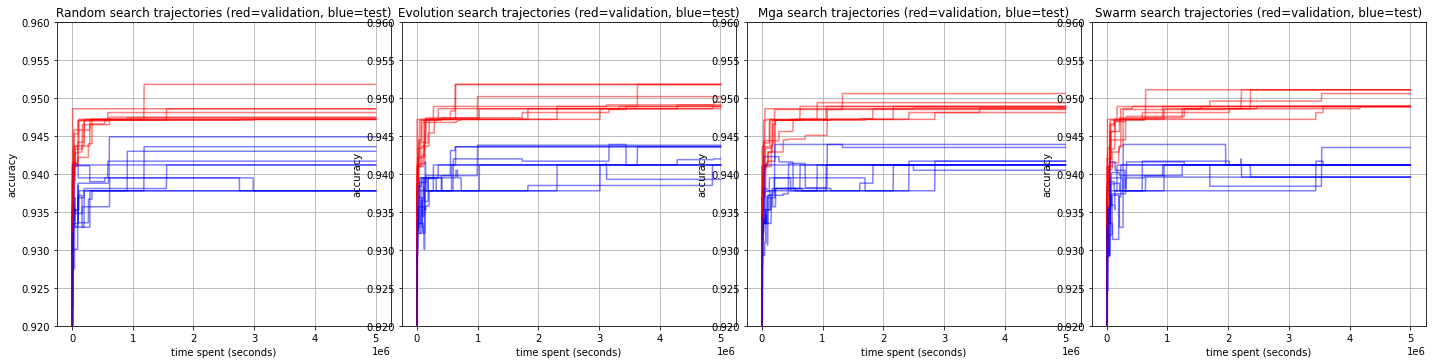

In [18]:
# 多个模型的绘图，加上random和进化
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
for times, best_valid, best_test in random_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.tight_layout()
plt.grid()
plt.title('Random search trajectories (red=validation, blue=test)')


plt.subplot(1, 4, 2)
for times, best_valid, best_test in evolution_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search trajectories (red=validation, blue=test)')


plt.subplot(1, 4, 3)
for times, best_valid, best_test in MGA_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Mga search trajectories (red=validation, blue=test)')

plt.subplot(1, 4, 4)
for times, best_valid, best_test in swarm_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Swarm search trajectories (red=validation, blue=test)')

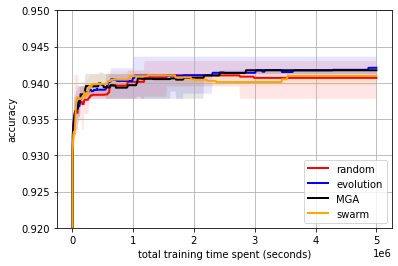

In [19]:
# Compare the mean test accuracy along with error bars.
def plot_data(data, color, label, gran=10000, max_budget=5000000):
  """Computes the mean and IQR fixed time steps."""
  xs = range(0, max_budget+1, gran)
  mean = [0.0]
  per25 = [0.0]
  per75 = [0.0]
  
  repeats = len(data)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget+1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(data[repeat][0]) and 
             data[repeat][0][pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = data[repeat][0][pointers[repeat]-1]
      prev_test = data[repeat][2][pointers[repeat]-1]
      next_time = data[repeat][0][pointers[repeat]]
      next_test = data[repeat][2][pointers[repeat]]
      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_time - prev_time)) * (next_test - prev_test) + prev_test
      
      all_vals.append(cur_val)
      
    all_vals = sorted(all_vals)
    mean.append(sum(all_vals) / float(len(all_vals)))
    per25.append(all_vals[int(0.25 * repeats)])
    per75.append(all_vals[int(0.75 * repeats)])
      
    cur += gran
    
  plt.plot(xs, mean, color=color, label=label, linewidth=2)
  plt.fill_between(xs, per25, per75, alpha=0.1, linewidth=0, facecolor=color)

plot_data(random_data, 'red', 'random')
plot_data(evolution_data, 'blue', 'evolution')
plot_data(MGA_data, 'black', 'MGA')
plot_data(swarm_data, 'orange', 'swarm')
plt.legend(loc='lower right')
plt.ylim(0.92, 0.95)
plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

In [25]:
s = run_particle_swarm_search()
for i in s:
    print(i[1])
    print(len(i))

284.24298095703125
2034
0.8358373641967773
2034
0.8410456776618958
2034


In [26]:
e = run_evolution_search()

for i in e:
    print(i[1])
    print(len(i))

944.1749877929688
2815
0.8827123641967773
2815
0.8844150900840759
2815
